In [1]:
import os
import sys
import pathlib
import math
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib import colormaps
from matplotlib.colors import colorConverter, ListedColormap
%matplotlib inline 
import pickle
import seaborn as sns

import numpy as np
import pandas as pd

from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS 
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite import plotting as tp

In [2]:
data_path = "E:/UG4data/Dublin/2019-06-18 Dublin data/"
output_path = "D:/ProgramData/Jupyter Notebook/UG4/results/Dublin/processed_data/"
subjects = list([f[:6] for f in os.listdir(data_path) if f.startswith('DB')])
subjects = list(dict.fromkeys(subjects))
len(subjects)

60

In [3]:
# Johnathan's code
def convert_datetime(datetime_col : pd.Series) -> pd.Series:
    return pd.to_datetime(datetime_col,utc=True).dt.tz_localize(None).astype('datetime64[s]')

def airspeck(subject: str):
    df = pd.read_csv(
        f"{data_path}{subject}_airspeck_personal.csv",
        usecols=["timestamp", "pm2_5", "temperature", "humidity"],
    )
    df["timestamp"] = convert_datetime(df["timestamp"])
    df = df.set_index("timestamp")
    return df

def respeck(subject: str):
    df= pd.read_csv(
        f"{data_path}{subject}_respeck.csv",
        usecols=["timestamp", "breathing_rate", "activity_level", "activity_type"],
    )
    df["timestamp"] = convert_datetime(df["timestamp"])
    df = df.set_index("timestamp")
    return df

def merged_recordings(subject: str):
    return merge_by_timestamp(respeck(subject), airspeck(subject))


def subject_details():
    return pd.read_csv(
        "./data/other/subject_details.csv",
        index_col=["subj_id"],
        usecols=["subj_id", "age", "gender", "diagnosis", "smoking_status"],
    )


def diagnosis(subject: str):
    return subject_details()["diagnosis"].loc[subject]


def smoking_status(subject: str):
    return subject_details()["smoking_status"].loc[subject]


def age(subject: str):
    return subject_details()["age"].loc[subject]


def gender(subject: str):
    return subject_details()["gender"].loc[subject]


def all_subjects():
    return list(subject_details().index)

def subjects_with_5x_exposure():
    return [s for s in all_subjects() if during_smoking(s).pm2_5.mean() >= 100]


def smoking_episodes():
    df = pd.read_csv(
        "./data/other/smoking_episodes.csv",
        index_col=["subj_id"],
    )
    df["shs_period_start"] = convert_datetime(df["shs_period_start"])
    df["shs_period_end"] = convert_datetime(df["shs_period_end"])
    return df


def before_smoking(subject: str):
    episode = smoking_episodes().loc[subject]
    start = episode["shs_period_start"] - pd.Timedelta(minutes=5)

    subject_df = merged_recordings(subject)
    return subject_df.loc[:start]


def during_smoking(subject: str):
    episode = smoking_episodes().loc[subject]
    start = episode["shs_period_start"]
    end = episode["shs_period_end"]

    subject_df = merged_recordings(subject)
    return subject_df.loc[start:end]


def after_smoking(subject: str, hours: int):
    episode = smoking_episodes().loc[subject]
    start = episode["shs_period_end"]
    end = start + pd.Timedelta(hours=hours)

    subject_df = merged_recordings(subject)
    return subject_df.loc[start:end]


def during_and_after_smoking(subject: str, hours: int):
    episode = smoking_episodes().loc[subject]
    start = episode["shs_period_start"]
    smoking_end = episode["shs_period_end"]
    end = smoking_end + pd.Timedelta(hours=hours)

    subject_df = merged_recordings(subject)
    return subject_df.loc[start:end]


def centered_on_smoking(subject: str, hours_before: int, hours_after: int):
    episode = smoking_episodes().loc[subject]
    start = episode["shs_period_start"] - pd.Timedelta(hours=hours_before)
    end = episode["shs_period_end"] + pd.Timedelta(hours=hours_after)

    subject_df = merged_recordings(subject)
    return subject_df.loc[start:end]

def smoking_one_hour(subject : str):
    episode = smoking_episodes().loc[subject]
    start = episode["shs_period_start"] 
    end = start + pd.Timedelta(hours=1)

    subject_df = merged_recordings(subject)
    return subject_df.loc[start:end]

def subjects_by_smoking_status():
    df = subject_details()
    non_smokers = list(df.loc[df["smoking_status"] == "Non Smoker"].index)
    ex_smokers = list(df.loc[df["smoking_status"] == "Ex Smoker"].index)
    curr_smokers = list(df.loc[df["smoking_status"] == "Current Smoker"].index)

    return non_smokers, ex_smokers, curr_smokers


def pickled_results(subject: str, tau_max: int, linear: bool):
    linear = "linear" if linear else "nonlinear"
    path = f"./data/pickles/{linear}/{tau_max}/{subject}.pickle"

    with open(path, "rb") as file:
        return pickle.load(file)


In [4]:
def process(
    df: pd.DataFrame,
    dropping_nans: bool = False,
    filling_nans: bool = False,
    differencing: bool = False,
    smoothing_column: str = "",
):
    assert dropping_nans != filling_nans

    df = interpolate(df, limit=10)
    df = difference(df) if differencing else df
    df = drop_nans(df) if dropping_nans else df
    df = smooth(df, smoothing_column) if smoothing_column else df
    df = fill_nans(df) if filling_nans else df
    return df

# def percentage_nan(df: pd.DataFrame):
#     return df.isna().mean() * 100

def remove_extreme_values(df: pd.DataFrame, lower: float, upper: float):
    return df.clip(lower=df.quantile(lower), upper=df.quantile(upper), axis=1)

def fill_nans(df: pd.DataFrame):
    # Why ????
    return df.fillna(999.0)
    #return df.interpolate(method="pad")


def drop_nans(df: pd.DataFrame):
    return df.dropna()


def interpolate(df: pd.DataFrame, limit: int):
    return df.interpolate(method="time", limit=limit, limit_direction="both")


def merge_by_timestamp(left: pd.DataFrame, right: pd.DataFrame):
    return pd.merge(left=left, right=right, on="timestamp")


def difference(df: pd.DataFrame):
    return df.diff()


def smooth(df: pd.DataFrame, column: str):
    df[column] = df[column].rolling(window="10T").mean()
    return df


In [5]:
def merge_data(subject):
    df_air = pd.read_csv(data_path + subject[0], parse_dates=["timestamp"], index_col=["timestamp"])[['temperature', 'humidity', 'pm2_5']]
    df_re = pd.read_csv(data_path + subject[1], parse_dates=["timestamp"], index_col=["timestamp"])[['breathing_rate', 'activity_level']]
    df = df_re.join(df_air)
    return df

# Jonathan's codes
def smoking_episodes():
    df = pd.read_csv(
        "E:/UG4data/Dublin/smoking_episodes.csv",
        infer_datetime_format=True,
        parse_dates=["shs_period_start", "shs_period_end"],
        date_parser=lambda col: pd.to_datetime(col, utc=True),
        index_col=["subj_id"],
    )
    df["shs_period_start"] = df["shs_period_start"].dt.tz_localize(None)
    df["shs_period_end"] = df["shs_period_end"].dt.tz_localize(None)
    return df


def before_smoking(subject: str):
    episode = smoking_episodes().loc[subject]
    start = episode["shs_period_start"] - pd.Timedelta(minutes=5)

    subject_df = merged_recordings(subject)
    return subject_df.loc[:start]


def during_smoking(subject: str):
    episode = smoking_episodes().loc[subject]
    start = episode["shs_period_start"]
    end = episode["shs_period_end"]

    subject_df = merged_recordings(subject)
    return subject_df.loc[start:end]


def after_smoking(subject: str, hours: int):
    episode = smoking_episodes().loc[subject]
    start = episode["shs_period_end"]
    end = start + pd.Timedelta(hours=hours)

    subject_df = merged_recordings(subject)
    return subject_df.loc[start:end]


In [12]:
for id in subjects:
    df = merged_recordings(id)[["breathing_rate", "activity_level", "pm2_5"]]
#     df = process(df[["breathing_rate", "activity_type", "pm2_5"]], filling_nans=True)
#     df.fillna(value=df['breathing_rate'].mean(), inplace=True)
    df = df.dropna()
    assert(not df.isnull().values.any())
    df.to_csv(output_path + id + ".csv", index=False)
df.head()

,breathing_rate,activity_level,pm2_5
timestamp,,,
2018-11-06 11:54:00,26.536612,0.068504,3.292136
2018-11-06 11:57:00,27.401494,0.112207,3.390674
2018-11-06 11:58:00,22.506919,0.112832,3.300169
2018-11-06 11:59:00,22.726604,0.150474,3.213636
2018-11-06 12:00:00,18.419563,0.246774,3.343882


In [16]:
df = pd.read_csv(f"{output_path}/DBCA01.csv")
df.describe()

,breathing_rate,activity_level,pm2_5
count,646.000000,646.000000,646.000000
mean,19.212778,0.056689,14.954982
std,4.261758,0.068029,43.282511
min,12.540701,0.006657,0.860047
25%,15.274306,0.014073,2.652344
50%,19.164003,0.029863,3.187291
75%,22.443131,0.063206,3.975438
max,38.662910,0.384465,362.774157


In [95]:
id = "DBCC14"
df = merged_recordings(id)
df = df[["breathing_rate", "activity_type", "pm2_5"]]
df.fillna(value=df['breathing_rate'].mean(), inplace=True)
max_br = max(df["breathing_rate"].dropna())
df["breathing_rate"] = df["breathing_rate"]/max_br
# df.to_csv(output_path + "Dublin/" + id + ".csv", index=False)
df.head(6)

,breathing_rate,activity_type,pm2_5
timestamp,,,
2019-04-11 11:15:00,0.572508,0,3.095517
2019-04-11 11:16:00,0.732667,0,3.304939
2019-04-11 11:17:00,0.699324,0,2.941362
2019-04-11 11:18:00,0.572508,0,2.716043
2019-04-11 11:19:00,0.572508,1,3.184329
2019-04-11 11:20:00,0.572508,1,3.957716


# PCMCI+

In [5]:
# Link assumptions
def get_la(tau_max):
    '''
    The function get_la requires the maximum lag `tau_max` 
    and returns the dictionary of dictionaries required for the `link_assumptions` hyperparameter. 
    Remember this is dependent on the order of the variables in the time series.
    '''
    
    link_assumptions = {}
    
    '''
    breathing_rate:
    
    Can be caused by any lag of any variable.
    Must have a contemporaneous link with activity_level, as the effect.
    May have contemporaneous links with temperature/humidity/pm2_5, as the effect.
    '''
    link_assumptions[0] = {(i, -tau): "-?>" for i in range(5) for tau in range(1, tau_max+1)}
    link_assumptions[0][(1,  0)] = "-->"
    for i in [2, 3, 4]:
        link_assumptions[0][(i, 0)] = "-?>"
        
    '''
    activity_level:
    
    Can be caused by any lag of any variable.
    May have a contemporaneous link with breathing_rate, as the cause.
    May have contemporaneous links with temperature/humidity/pm2_5, as the effect.
    '''
    link_assumptions[1] = {(i, -tau): "-?>" for i in range(5) for tau in range(1, tau_max+1)}
    link_assumptions[1][(0,  0)] = "<--"
    for i in [2, 3, 4]:
        link_assumptions[1][(i, 0)] = "-?>"
        
    '''
    temperature:
    
    Can be caused by any lag of itself, humidity or pm2_5.
    May have a contemporaneous link with breathing_rate/activity_level, as the cause.
    May have contemporaneous effects with humidity/pm2_5, as the cause or effect.
    '''
    link_assumptions[2] = {(i, -tau): "-?>" for i in [2, 3, 4] for tau in range(1, tau_max+1)}
    link_assumptions[2][(0,  0)] = "<?-"
    link_assumptions[2][(1,  0)] = "<?-"
    for i in [3, 4]:
        link_assumptions[2][(i, 0)] = "o?o"
        
    '''
    humidity:
    
    Can be caused by any lag of itself, temperature or pm2_5.
    May have a contemporaneous link with breathing_rate/activity_level, as the cause.
    May have contemporaneous effects with temperature/pm2_5, as the cause or effect.
    '''
    link_assumptions[3] = {(i, -tau): "-?>" for i in [2, 3, 4] for tau in range(1, tau_max+1)}
    link_assumptions[3][(0,  0)] = "<?-"
    link_assumptions[3][(1,  0)] = "<?-"
    for i in [2, 4]:
        link_assumptions[3][(i, 0)] = "o?o"
        
    '''
    pm2_5:
    
    Can be caused by any lag of itself, temperature or humidity.
    May have a contemporaneous link with breathing_rate/activity_level, as the cause.
    May have contemporaneous effects with temperature/humidity, as the cause or effect.
    '''
    link_assumptions[4] = {(i, -tau): "-?>" for i in [2, 3, 4] for tau in range(1, tau_max+1)}
    link_assumptions[4][(0,  0)] = "<?-"
    link_assumptions[4][(1,  0)] = "<?-"
    for i in [2, 3]:
        link_assumptions[4][(i, 0)] = "o?o"
        
    return link_assumptions

In [26]:
def pcmci_plus(subject, resolution, test, tau_max, pc_alpha=0.0001, window_size=4):
    name = subject[0][:6]
    print(f"+++ Running {name} on {test} +++")
    output_folder = f"results/PCMCI+/{test}_r{resolution}t{tau_max}"
    if test in ["wls_parcorr", "robust_wls_parcorr"]:
        output_folder = output_folder + f"_w{window_size}"
#     if pathlib.Path(f"{output_folder}/{name}.pickle").exists():
#         print("  Already exist")
#         return
    
    # Read Processed data
    df = merge_data(subject)
    var_names = ['breathing_rate', 'activity_level', 'temperature', 'humidity', 'pm2_5']
    df = df[var_names]
    if len(df) - (df.isna().sum(axis=1) == 5).sum() < 10:
        print(f"No enough data for {name}")
        return
    
    # Handle missing values
    df.fillna(999., inplace=True)
    dataframe = pp.DataFrame(df.values, 
                             var_names=var_names, 
                             missing_flag=999.)
    
    # Initialise whichever conditional indpendence test we are going to use.
    if test == "parcorr":
        ci_test = ParCorr()
    elif test == "robust_parcorr":
        ci_test = RobustParCorr()
    elif test == "wls_parcorr":
        ci_test = ParCorrWLS(window_size=window_size)
    elif test == "robust_wls_parcorr":
        ci_test = ParCorrWLS(window_size=window_size, robustify=True)
    elif test == "gpdc":
        ci_test = GPDC()
    elif test == "cmi":
        ci_test = CMIknn()
        
    # Run pcmci+
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)
#     results = pcmci.run_pcmciplus(tau_max=tau_max, pc_alpha=pc_alpha, link_assumptions=get_la(tau_max), reset_lagged_links=True)
    try:
        results = pcmci.run_pcmciplus(tau_max=tau_max, pc_alpha=pc_alpha, link_assumptions=get_la(tau_max), reset_lagged_links=True)
    except:
        print(f"  Not able to run pcmci+ for {name} on {test}")
        return
#     tp.plot_graph(graph=results['graph'], var_names=var_names)
#     plt.show()

    # Save result obejct
    pathlib.Path(output_folder).mkdir(parents=True, exist_ok=True)
    outfile = open(f"{output_folder}/{name}.pickle", "wb")
    pickle.dump(results, outfile)
    outfile.close()
    print("  Done")

In [67]:
# tests = ["wls_parcorr", "parcorr", "robust_wls_parcorr", "robust_parcorr", "gpdc", "cmi"] # CMIknn too slow
tests = ["wls_parcorr"]
resolution = 1; tolerence = 1
window_size = 15; tau_max = 30; pc_alpha = 0.05

# Run the algorithm for every conditional independence test
for test in tests:
    print(f"========== Run {test} ==========")
    # Run the algorithm for every subject
    for subject in subjects:
        print()
        # Run only for those IDs we haven't done yet.
        pcmci_plus(subject, resolution, test, tau_max, pc_alpha, window_size)

========== Run wls_parcorr ==========

+++ Running DBCA01 on wls_parcorr +++
  Done

+++ Running DBCA02 on wls_parcorr +++
  Done

+++ Running DBCA04 on wls_parcorr +++
  Done

+++ Running DBCA05 on wls_parcorr +++
  Done

+++ Running DBCA06 on wls_parcorr +++
  Done

+++ Running DBCA07 on wls_parcorr +++
  Done

+++ Running DBCA10 on wls_parcorr +++
  Done

+++ Running DBCA11 on wls_parcorr +++
  Done

+++ Running DBCA12 on wls_parcorr +++
  Done

+++ Running DBCA15 on wls_parcorr +++
  Done

+++ Running DBCC01 on wls_parcorr +++
  Done

+++ Running DBCC02 on wls_parcorr +++
  Done

+++ Running DBCC03 on wls_parcorr +++
  Done

+++ Running DBCC04 on wls_parcorr +++
  Done

+++ Running DBCC06 on wls_parcorr +++
  Done

+++ Running DBCC07 on wls_parcorr +++
  Done

+++ Running DBCC08 on wls_parcorr +++
  Done

+++ Running DBCC09 on wls_parcorr +++
  Done

+++ Running DBCC10 on wls_parcorr +++
  Done

+++ Running DBCC11 on wls_parcorr +++
  Done

+++ Running DBCC12 on wls_parcorr +++
  D

d:\programs\python\python3.8.10\lib\site-packages\tigramite\independence_tests\parcorr_wls.py:334: RuntimeWarning: divide by zero encountered in reciprocal
  weights = np.diag(np.reciprocal(stds))


  Not able to run pcmci+ for DBIA09 on wls_parcorr

+++ Running DBIA10 on wls_parcorr +++
  Done

+++ Running DBIC01 on wls_parcorr +++
  Not able to run pcmci+ for DBIC01 on wls_parcorr

+++ Running DBSA03 on wls_parcorr +++
  Done

+++ Running DBSA04 on wls_parcorr +++
  Done

+++ Running DBSA05 on wls_parcorr +++
  Done

+++ Running DBSA06 on wls_parcorr +++
  Done

+++ Running DBSA07 on wls_parcorr +++
  Done

+++ Running DBSA08 on wls_parcorr +++
  Done

+++ Running DBSA09 on wls_parcorr +++
  Done

+++ Running DBSA10 on wls_parcorr +++
  Done

+++ Running DBSA11 on wls_parcorr +++
  Done

+++ Running DBSA12 on wls_parcorr +++
  Not able to run pcmci+ for DBSA12 on wls_parcorr

+++ Running DBSC01 on wls_parcorr +++
  Done

+++ Running DBSC02 on wls_parcorr +++
  Done

+++ Running DBSC03 on wls_parcorr +++
  Done

+++ Running DBSC04 on wls_parcorr +++
  Done

+++ Running DBSC05 on wls_parcorr +++
  Done

+++ Running DBSC06 on wls_parcorr +++
  Done

+++ Running DBSC07 on wls_parcor

In [106]:
def heatmap_colormap_1():
    mapping = colormaps['viridis']
    newcolors = mapping(np.linspace(0, 1, 256))
    newcolors[:13, :] = np.array(colorConverter.to_rgba('forestgreen'))
    newcolors[13:, :] = np.array(colorConverter.to_rgba('tomato'))
    return ListedColormap(newcolors)

def heatmap(df, title, savefig=""):
    # Plots and labels
    h = math.ceil(max(len(df.index)*5/25, 2))
    fig, ax = plt.subplots(figsize=(8, h))
    sns.heatmap(df, vmin = 0, vmax = 1 ,cmap = heatmap_colormap_1())
    ax.set_xticks(np.arange(0.5, 31.5, 5))
#     ax.set_yticks(np.arange(0.5, len(ids)+0.5, 1))
    ax.set_xticklabels(np.arange(0, 31, 5), rotation=0)
#     ax.set_yticklabels(ids, fontsize=8)
    ax.set_ylabel('ID')
    ax.set_xlabel('Time Delay (min)')
    ax.set_title(title)
    plt.tight_layout()
#     if not savefig == "":
#         plt.savefig(f"graphs/PCMCI+ heatmap/{savefig}", dpi=300)
    plt.show()

def loadPCMCI(path, variable_num):
    files = [f[:6] for f in os.listdir(path)]
    dfs = [pd.DataFrame()]*variable_num
    
    for id in list(files):
        file = open(f"{path}/{id}.pickle", "rb")
        result = pickle.load(file)
        for i in range(variable_num):
            dfs[i] = pd.concat([dfs[i], pd.DataFrame(result["p_matrix"][i, 0, :], columns=[id]).T])
        file.close()
        
    return dfs, files
    
def loadPCMCI_by_Diagnosis(path, variable_num):
    files = [f[:6] for f in os.listdir(path)]
    dfs_A = [pd.DataFrame()]*variable_num
    dfs_C = [pd.DataFrame()]*variable_num
    
    for id in list(files):
        file = open(f"{path}/{id}.pickle", "rb")
        result = pickle.load(file)
        for i in range(variable_num):
            if id[3] == 'A':
                dfs_A[i] = pd.concat([dfs_A[i], pd.DataFrame(result["p_matrix"][i, 0, :], columns=[id]).T])
            elif id[3] == 'C':
                dfs_C[i] = pd.concat([dfs_C[i], pd.DataFrame(result["p_matrix"][i, 0, :], columns=[id]).T])
        file.close()
        
    return dfs_A, dfs_C, files

In [95]:
dfs_A, dfs_C, ids = loadPCMCI_by_Diagnosis("results/PCMCI+/wls_parcorr_r1t30_w15", 5)

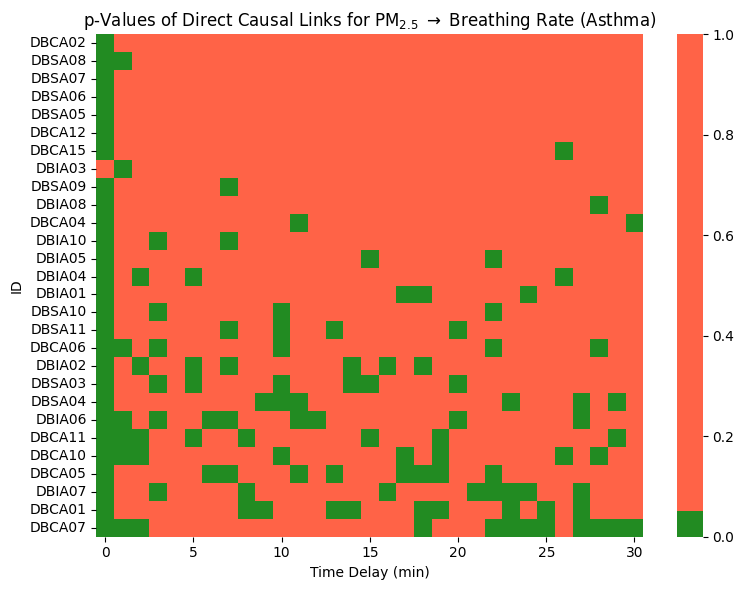

In [98]:
dfs_A_br = dfs_A[4].copy()
dfs_A_br["ncl"] = (dfs_A_br < 0.05).sum(axis=1)
dfs_A_br.sort_values(by=["ncl"], inplace=True)
dfs_A_br.drop(columns=["ncl"], inplace=True)
heatmap(dfs_A_br, "p-Values of Direct Causal Links for PM$_{2.5}$ $\\rightarrow$ Breathing Rate (Asthma)")

# TMLE

In [6]:
df = pd.read_csv("D:/ProgramData/Jupyter Notebook/UG4/results/Dublin/TMLE/result5.csv") 
df.columns=["subject", "est", "se"]
df_C = df[df["subject"].str[3] == 'C'].sort_values("subject", ascending=False)
df_C['diagnosis'] = 'COPD'
df_A = df[df["subject"].str[3] == 'A'].sort_values("subject", ascending=False)
df_A['diagnosis'] = 'Asthma'
df = df_C.merge(df_A, how='outer')
df

,subject,est,se,diagnosis
0,DBCC01,-0.007190,0.005956,COPD
1,DBCA15,0.034406,0.009588,Asthma
2,DBCA12,0.015259,0.006222,Asthma
3,DBCA11,-0.013690,0.004601,Asthma
4,DBCA10,-0.009445,0.005465,Asthma
5,DBCA07,0.017802,0.008334,Asthma
6,DBCA06,-0.047123,0.013043,Asthma
7,DBCA05,0.019383,0.004125,Asthma
8,DBCA04,0.032756,0.006504,Asthma
9,DBCA02,0.007374,0.012410,Asthma


In [7]:
df_A.sort_values(by=['est'])

,subject,est,se,diagnosis
4,DBCA06,-0.047123,0.013043,Asthma
7,DBCA11,-0.013690,0.004601,Asthma
6,DBCA10,-0.009445,0.005465,Asthma
1,DBCA02,0.007374,0.012410,Asthma
8,DBCA12,0.015259,0.006222,Asthma
5,DBCA07,0.017802,0.008334,Asthma
3,DBCA05,0.019383,0.004125,Asthma
2,DBCA04,0.032756,0.006504,Asthma
9,DBCA15,0.034406,0.009588,Asthma
0,DBCA01,0.044385,0.012987,Asthma


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


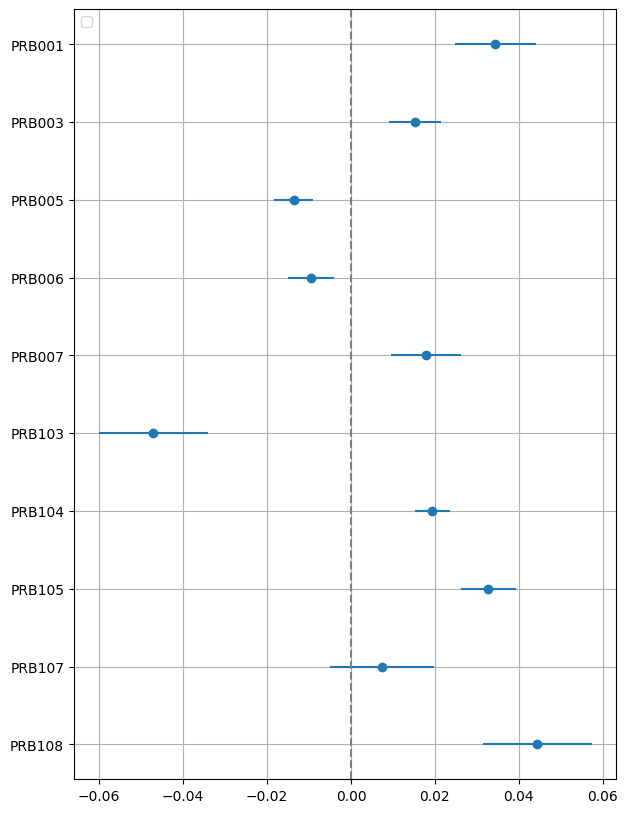

In [16]:
plt.figure(figsize=(7, 10))
plt.errorbar(df_A['est'], df_A['subject'], xerr=df_A['se'], linestyle='None', fmt='o')
plt.axvline(x=0, color='red', linestyle='--', c='grey')
plt.legend(loc="upper left")
plt.gca().invert_yaxis()
plt.yticks(range(10), ['PRB001', 'PRB003', 'PRB005', 'PRB006', 'PRB007', 'PRB103',
          'PRB104', 'PRB105', 'PRB107', 'PRB108'])
plt.grid(True)

In [ ]:
sns.pointplot('est', 'subject', hue='diagnosis',
    data=sns.load_dataset(df), dodge=True, join=False)